In [235]:
## BLOCK 1 OF CODE _ reads the counter log file during workload execution and then captures the lines 

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the provided file
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_12_Summary_tmaL1_schedutil.txt'  #tmal3mem  - very highest correlation !!  - case 1 
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_28_L1cacheThrashing_ondemand_attempt2.txt' # Case 1b ->  Moderately correlating to the CacheMisses group events  
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_10_Summary_tmaL1_matrixthreads1_schedutil.txt' # single threaded matrix operation with tmal1 - case 2 - very low correlation ! 
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_15_branchMisses_schedutil_attempt1.txt' #branch prediction errors forced - very high correlation - case 3 (Block 4 has highest correlation)
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_5_pipeline_schedutil.txt' #dump pipeline counters - case 4
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_30_LLC_Affinity_ondemand_attempt1.txt' # case 5a (Block 3 an 4) affinity - not much correlating = meaning the LLC Cache affinity workload is not percolating to the error on "Cache" Counters
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_31_LLC_Affinity_ondemand_attempt2.txt' # case 5b -  affinity - Moderate to high correlation  = meaning the LLC Cache affinity correlates to TmaL3Mem counters !!
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_17_AVX_FPU_SSE_schedutil.txt' # instruction set over the stress workload, TopdownL5 - case 6
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_18_AVX_FPU_SSE_schedutil_attempt2.txt' # here we selected set of new counter sets from TMA which are a group tma_L5_group - case 7
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_19_Cache_Tests.txt' # cache intensive workloads - case 8
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_20_Cache_Tests_attempt2.txt' # cache intensive workloads - case 8b - very poor correlation
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_21_Cache_Tests_attempt3.txt' # cache intensive workloads - case 8c - very poor correlation
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_22_Cache_Tests_attempt4.txt' # cache intensive workloads - case 8d - very poor correlation
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_23_Cache_Tests_attempt5.txt' # cache intensive workloads - case 8d - very poor correlation
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_24_Cache_Tests_attempt6.txt' # cache intensive workloads - case 8d - somewhat ok correlation
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_25_Cache_Tests_attempt7.txt' # cache intensive workloads - case 8d - poor-correlation to TmaL1
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_26_Cache_Tests_attempt8.txt' # cache intensive workloads - case 8d - poor-correlation to TmaL3Mem
file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_13_Summary_tmaL2_schedutil.txt' #summary, tmal1   - high correlation !! - case 9

#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_27_L1cacheThrashing_ondemand_attempt1.txt' #not correlating to the TMAL1 and Summary events
#file_path = '/home/drdang/phD/thesis/tools/perf/stress_computeCounters_29_L1cacheThrashing_monitoringL2Behav_ondemand_attempt3.txt' # No case set  - not correlating - OMIT FOR NOW 


# Since the data seems to have a structured layout, we'll load it while ignoring potential non-tabular lines.
# Let's filter the data into relevant columns, assuming a general structure.
lines = []
with open(file_path, 'r') as file:
    for line in file:
        # Try to extract lines with timestamps and counter values
        if line.strip() and any(c.isdigit() for c in line):
            lines.append(line.strip())
# Previewing the first few lines to determine structure

lines[:40] 

['drdang@drdang-Inspiron-14-7430-2-in-1:~/phD/thesis/tools/perf$ sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M Summary,TmaL1 /usr/bin/stress-ng --matrix 12 --timeout 100s --thermalstat 1',
 'stress-ng: info:  [254859] setting to a 1 min, 40 secs run per stressor',
 'stress-ng: info:  [254859] dispatching hogs: 12 matrix',
 '1.003507946  1,45,58,37,44,947      cpu_core/TOPDOWN.SLOTS/          # 145583744947.00 tma_info_thread_slots',
 '1.003507946                                                   #     2.00 tma_info_thread_slots_utilization',
 '1.003507946                                                   #     30.4 %  tma_backend_bound',
 '1.003507946                                                   #     46.8 %  tma_retiring             (26.78%)',
 '1.003507946    67,74,33,80,770      cpu_core/topdown-retiring/                                              (26.78%)',
 '1.003507946       91,74,14,831      cpu_core/topdown-bad-spec/                            

In [236]:
## BLOCK 2 OF CODE _ Pulls out the Temperature and Frequency from another matrix and adjusts the time inline into a single parsable sequence over timestamp

#this code is to prepare a readjusted buffer with temperature value along with all other counters in the same table.
#At the end of this code, we will have a buffer with timestamp added to the stress-ng string which holds other CPU statistics.
import re

temperatureString = None
readjustValues =  False
skipThisTime = False

readjustedList = []

for line in lines: 

    if re.search("stress-ng", line):
        temperatureString = line
        #print (f"{temperatureString}")
        readjustValues = False
        skipThisTime = True

    elif skipThisTime == True:
        readjustValues = True
        skipThisTime = False

    readjustedList.append(line)
    
    if skipThisTime == True:
        continue
    
    if readjustValues == True and skipThisTime == False: # we already found one stressng string here 
        #pull the timestamp from the line now assuming this is the next line (Non stressng one)
        pattern = r"(\d+.\d+\s+)"
        timestamp = re.findall(pattern, line)
        if timestamp:
            #print (f"{timestamp[0]}  {temperatureString}")
            readjustedList.append(f"{timestamp[0]}  {temperatureString}")
            readjustValues = False
            temperatureString = None


readjustedList

['drdang@drdang-Inspiron-14-7430-2-in-1:~/phD/thesis/tools/perf$ sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M Summary,TmaL1 /usr/bin/stress-ng --matrix 12 --timeout 100s --thermalstat 1',
 'stress-ng: info:  [254859] setting to a 1 min, 40 secs run per stressor',
 'stress-ng: info:  [254859] dispatching hogs: 12 matrix',
 '1.003507946  1,45,58,37,44,947      cpu_core/TOPDOWN.SLOTS/          # 145583744947.00 tma_info_thread_slots',
 '1.003507946    stress-ng: info:  [254859] dispatching hogs: 12 matrix',
 '1.003507946                                                   #     2.00 tma_info_thread_slots_utilization',
 '1.003507946                                                   #     30.4 %  tma_backend_bound',
 '1.003507946                                                   #     46.8 %  tma_retiring             (26.78%)',
 '1.003507946    67,74,33,80,770      cpu_core/topdown-retiring/                                              (26.78%)',
 '1.003507946     

In [187]:
## BLOCK 3 OF CODE _ reads the TOPDOWN Architectural events for core and atom architectures - ex. tma_backend_bound, tma_frontend_bound etc...
#run it exclusive of BLOCK 4 of code 

#this code is used for the TMA based analysis of the frontend and backend counters

import re

# Columns for structured data
columns = ['timestamp', 'category', 'coretype', 'metadata','metric', 'frequency', 'PCore-Temp', 'ECore-Temp']

parsed_data = []
gcore_type = ""
gcore_category = ""
for line in readjustedList:
    # Regex to extract timestamp, value, metric, and metadata
    match = re.match(r'(\d+\.\d+)\s+([\w./-]+)\s+\(([\w./-]+)\)\s+#\s+(\d+.\d+)\s+%\s+(tma_[a-z,A-Z,-,_]+)', line)
    match2 = re.match(r'(\d+\.\d+)\s+#\s+(\d+.\d+)\s+%\s+(tma_[a-z,A-Z,-,_]+)', line)
    match3 = re.match(r'(\d+\.\d+)\s+stress-ng.*therm:\s+(\d+\.\d+)', line)
    if match:
        timestamp, category, coretype, metadata, metric = match.groups()
        gcore_type = coretype
        gcore_category = category
        metric = gcore_type + "_" + metric
        # Clean and convert data
        if metadata == None: 
            metadata = float(0)
        parsed_data.append([float(timestamp), category, coretype, float(metadata.strip()), metric.strip(),0,0,0])

    elif match2:
        timestamp, metadata, metric = match2.groups()
        metric = gcore_type + "_" + metric
        # Clean and convert data
        if metadata == None: 
            metadata = float(0)
        parsed_data.append([float(timestamp), gcore_category, gcore_type, float(metadata.strip()), metric.strip(),0,0,0])

    elif match3:    
            #timestamp, frequency = match.groups()
            #print(f"{timestamp, frequency}")

            # Regex to match all floating-point numbers
            pattern = r"\d+\.\d+"
            # Find all matches
            matches = re.findall(pattern, line)
            if matches:
                # Select specific positions: 1st (3.40), 10th (86.05), and 11th (91.00)
                positions = [0,1, 10, 11]  # Adjusted for zero-based indexing
                selected_values = [matches[pos] for pos in positions]
                #print(selected_values[0], selected_values[1], selected_values[2],  selected_values[3])
                parsed_data.append([float(selected_values[0]), gcore_category, gcore_type, float(selected_values[1]), "CPU_Stats_Frequency" ,0,0,0])
                parsed_data.append([float(selected_values[0]), gcore_category, gcore_type, float(selected_values[2]), "CPU_Stats_PCore-Temp",0,0,0])
                parsed_data.append([float(selected_values[0]), gcore_category, gcore_type, float(selected_values[3]), "CPU_Stats_ECore-Temp",0,0,0])

# Convert parsed data into a DataFrame
df = pd.DataFrame(parsed_data, columns=columns)
# Display a summary of the parsed data for validation


#df.head(50)
#len(df)


In [237]:
## BLOCK 4 OF CODE _ reads the TOPDOWN Architectural not the percentage value but rather the absolute counters ! 
#run it exclusive of BLOCK 3 of code 


#this code is used for the TMA L3 based analysis of the frontend and backend counters
# this is TMA L3 counter !!
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M TmaL3mem /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1 
#same code will work for summary also which is below => 
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M summary /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1
#same code will work for summary also which is below => 
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M TmaL1 /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1
#same code will work for summary also which is below => 
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M TmaL2 /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1

import re

# Columns for structured data
columns = ['timestamp', 'metadata','metric', 'frequency', 'PCore-Temp', 'ECore-Temp']

parsed_data = []

for line in readjustedList:
    # Regex to extract timestamp, value, metric, and metadata
    match = re.match(r'(\d+\.\d+)\s+([\d,]+)\s+([\w./-]+)', line)
    match2 = re.match(r'(\d+\.\d+)\s+([\d+,\d+.*]+)\s+([\w./-]+)\s+([\w./-]+)\s+#\s+(\d+.\d+)\s([a-z,A-Z,-,_]+)', line) # for this string => '1.001080723           6,127.01 msec task-clock                       #    6.127 CPUs utilized',
    match3 = re.match(r'(\d+\.\d+)\s+stress-ng.*therm:\s+(\d+\.\d+)', line)
    if match:
        timestamp, metadata, metric = match.groups()
        # Clean and convert data
        metadata = metadata.replace(",", "")
        if metadata == None: 
            metadata = float(0)
        parsed_data.append([float(timestamp), float(metadata.strip()), metric.strip(),0,0,0])

    elif match2:
        timestamp, metadata, unit, metric, val, utilized  = match2.groups()
        # Clean and convert data
        metadata = metadata.replace(",", "")
        if metadata == None: 
            metadata = float(0)
        parsed_data.append([float(timestamp), float(metadata.strip()), metric.strip(),0,0,0])

    
    if match3:    
        # Regex to match all floating-point numbers
        pattern = r"\d+\.\d+"
        # Find all matches
        matches = re.findall(pattern, line)
        if matches:
            # Select specific positions: 1st (3.40), 10th (86.05), and 11th (91.00)
            positions = [0,1, 10, 11]  # Adjusted for zero-based indexing
            selected_values = [matches[pos] for pos in positions]
            #print(selected_values[0], selected_values[1], selected_values[2],  selected_values[3])
            parsed_data.append([float(selected_values[0]),float(selected_values[1])*10, "CPU_Stats_Frequency" ,0,0,0])
            parsed_data.append([float(selected_values[0]),float(selected_values[2]), "CPU_Stats_PCore-Temp",0,0,0])
            parsed_data.append([float(selected_values[0]),float(selected_values[3]), "CPU_Stats_ECore-Temp",0,0,0])

# Convert parsed data into a DataFrame
df = pd.DataFrame(parsed_data, columns=columns)
# Display a summary of the parsed data for validation
numSamples = len(df)



0       NaN
1     88.05
2     91.05
3     91.05
4     91.05
      ...  
95    75.05
96    75.05
97    76.05
98    75.05
99      NaN
Name: CPU_Stats_PCore-Temp, Length: 100, dtype: float64


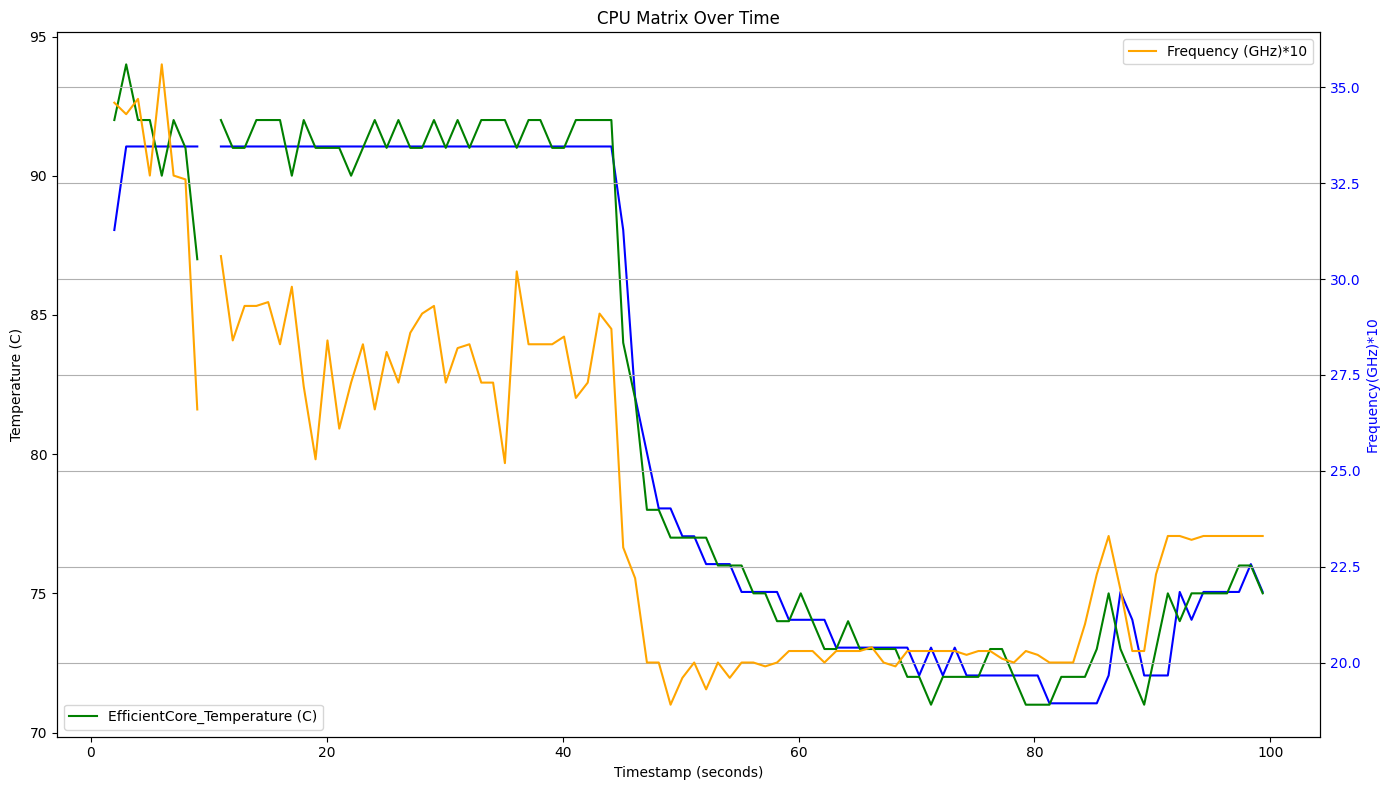

In [238]:
## BLOCK 5 OF CODE _ reads the following real target data !!
#data read from the real hardware - frequency, pcore temperature and ecore temperature

import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(14, 8))

# Sort frequency values (optional, as Matplotlib does this by default)
#sorted_frequency = np.sort(df['frequency'])

def getCPUStatBuffer(parameter):
    prev = float(pivoted_df[parameter][0])
    index = 0
    cpuStats_array = [] 
    for idx in range (0, len(pivoted_df[parameter])):
        value = pivoted_df[parameter][idx]
        if value == 0:
            cpuStats_array.append(float(prev))
        else:
            prev = value
            cpuStats_array.append(float(value))
        index = index + 1
    
    
    # Calculate min, max, and average
    min_val = min(cpuStats_array)
    max_val = max(cpuStats_array)
    avg_val = sum(cpuStats_array) / len(cpuStats_array)
    
    # Find indices of min and max for labeling
    max_idx = cpuStats_array.index(max_val)
    min_idx = cpuStats_array.index(min_val)

    
    # Plot the data
    #plt.plot(cpuStats_array, marker='o', label='frequency_range')
    
    # Add labels for min, max, and average
    plt.text(pivoted_df['timestamp'][min_idx], min_val, f"Min: {min_val}", color='blue')
    plt.text(pivoted_df['timestamp'][max_idx], max_val, f"Max: {max_val}",  color='red')

    return cpuStats_array

# Add average as a horizontal line
#plt.axhline(avg_val, color='green', linestyle='--', label=f"Average: {avg_val:.2f}")
#plt.text(len(pivoted_df['timestamp'])- 1, avg_val, f"Avg: {avg_val:.2f}", va='bottom', color='green')

cpuStatData = getCPUStatBuffer("CPU_Stats_PCore-Temp")
# Plot sorted frequency over timestamp
line1, = ax1.plot(pivoted_df['timestamp'], cpuStatData, label='PerformanceCore_Temperature (C)', color='blue')
print (pivoted_df['CPU_Stats_PCore-Temp'])

cpuStatData = getCPUStatBuffer("CPU_Stats_ECore-Temp")
# Plot sorted frequency over timestamp
line2, = ax1.plot(pivoted_df['timestamp'], cpuStatData, label='EfficientCore_Temperature (C)', color='green')

# Ensure y-axis is sorted from lower to higher
#ax1.set_ylim(bottom=sorted_frequency.min(), top=sorted_frequency.max())

# Create secondary axis
cpuStatData = getCPUStatBuffer("CPU_Stats_Frequency")
ax2 = ax1.twinx()  # Create a twin y-axis
line3, = ax2.plot(pivoted_df['timestamp'], cpuStatData, label='Frequency (GHz)*10', color='orange')
ax2.set_ylabel('Frequency(GHz)*10', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel("Temperature (C)")
ax1.set_xlabel("Timestamp (seconds)")
plt.title("CPU Matrix Over Time")
samples = len(cpuStatData)
samples = "CPU Metrics: " + str(samples) + " Samples"
#plt.legend(title=samples, fontsize=12)

# Add legends
legend1 = ax1.legend(handles=[line1], loc='upper left')  # Legend for primary axis
legend2 = ax1.legend(handles=[line2], loc='lower left')  # Legend for secondary axis
legend3= ax2.legend(handles=[line3], loc='upper right')  # Legend for secondary axis (Frequency)

plt.grid(True)
fig.tight_layout()  # Ensure labels don't overlap
plt.show()


TSC
cpu_atom/CPU_CLK_UNHALTED.CORE/
cpu_atom/CPU_CLK_UNHALTED.CORE/k
cpu_atom/CPU_CLK_UNHALTED.REF_TSC/
cpu_atom/INST_RETIRED.ANY/
cpu_core/CPU_CLK_UNHALTED.REF_TSC/
cpu_core/CPU_CLK_UNHALTED.THREAD/
cpu_core/INST_RETIRED.ANY/
cpu_core/INT_MISC.UOP_DROPPING/
cpu_core/TOPDOWN.SLOTS/
cpu_core/topdown-bad-spec/
cpu_core/topdown-be-bound/
cpu_core/topdown-br-mispredict/
cpu_core/topdown-fe-bound/
cpu_core/topdown-fetch-lat/
cpu_core/topdown-heavy-ops/
cpu_core/topdown-mem-bound/
cpu_core/topdown-retiring/
ns
cpu_core/CPU_CLK_UNHALTED.DISTRIBUTED/
CPU_Stats_ECore-Temp
to be plotted separately
CPU_Stats_Frequency
to be plotted separately
CPU_Stats_PCore-Temp
to be plotted separately


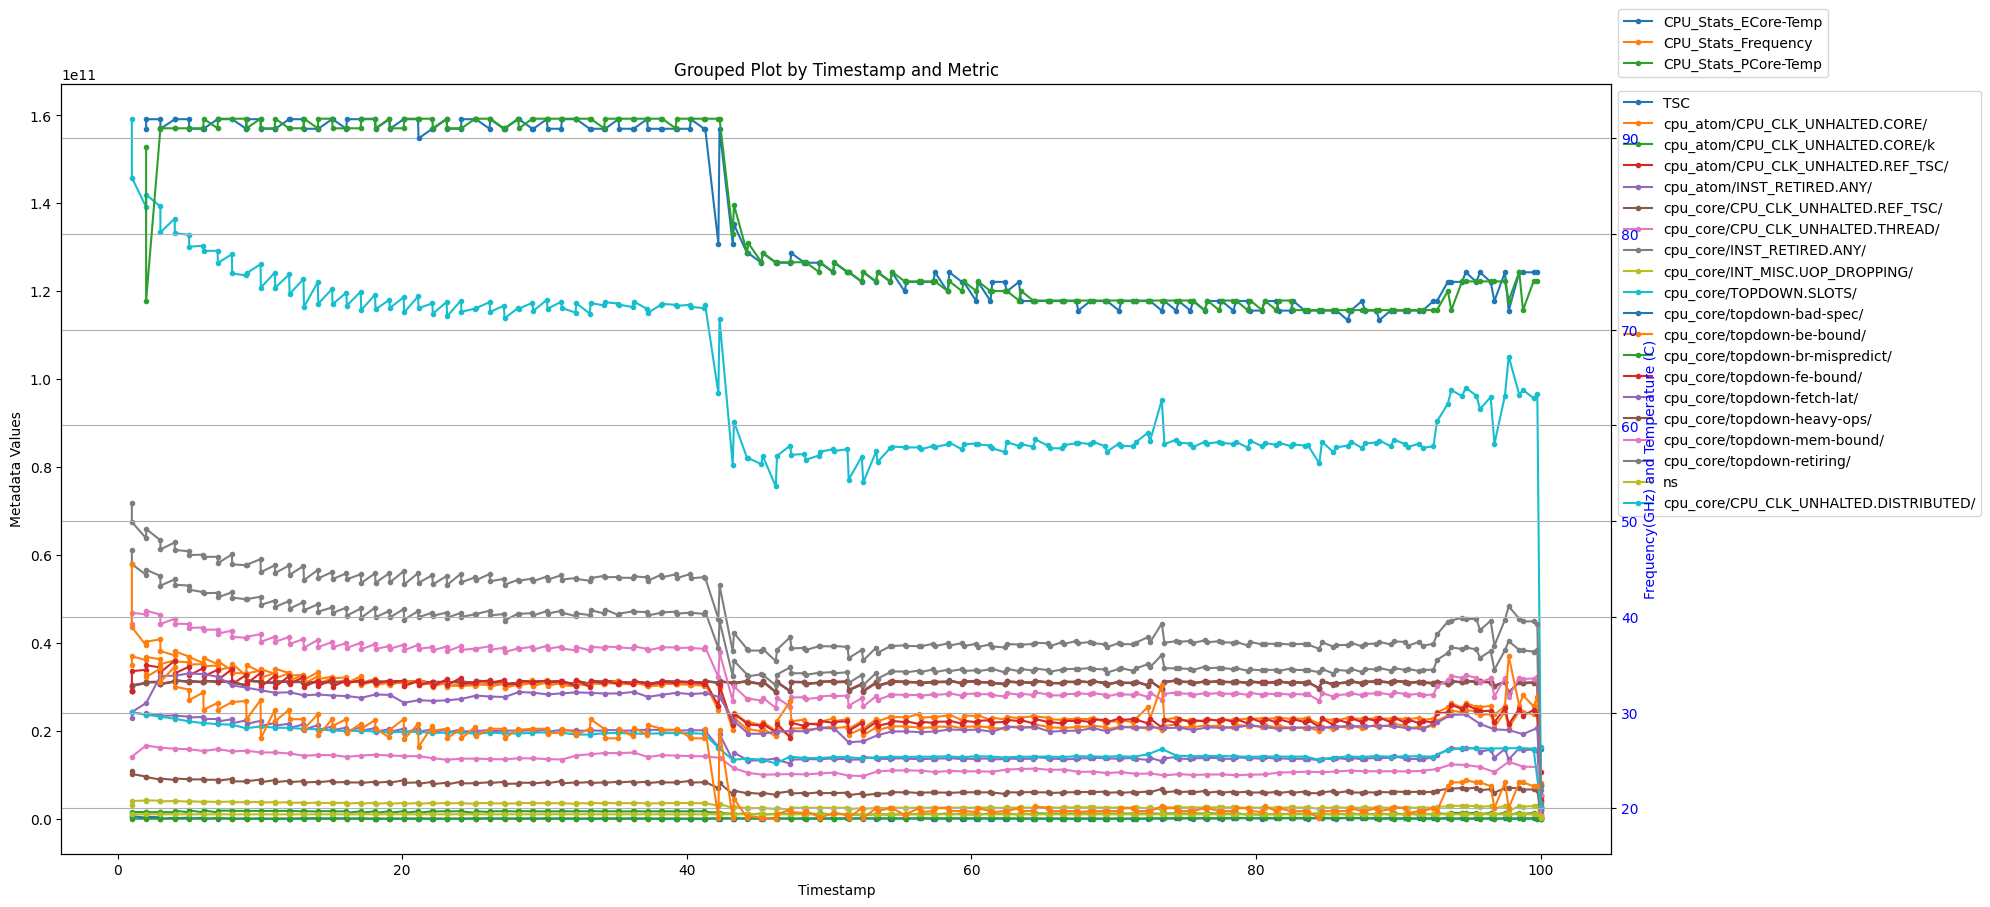

In [239]:

## BLOCK 6 OF CODE _ Plots all the counters along with target temperature of P-CORES. 

# Reading and parsing the text file which has this command run 
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M Frontend_Bound,Backend_Bound,Bad_Speculation,Retiring /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1
#same code will work for summary also which is below => 
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M Summary /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1
#same code will work for summary also which is below => 
#sudo /home/drdang/phD/thesis/linux-6.6.8/tools/perf/perf stat -I 1000 -M TmaL2 /usr/bin/stress-ng --matrix 35 --timeout 50s --thermalstat 1

# Group data by 'timestamp' and 'metric' and aggregate 'metadata', 'PCore-Temp', and 'ECore-Temp'

grouped_data = df.groupby(['timestamp', 'metric']).agg({
    'metadata': 'mean',
    'PCore-Temp': 'mean',
    'ECore-Temp': 'mean'
}).reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Create secondary axis
ax2 = ax.twinx()  # Create a twin y-axis

# Plot grouped data
for metric in grouped_data['metric'].unique():
    subset = grouped_data[grouped_data['metric'] == metric]
    print(f"{metric}")
    if metric == "CPU_Stats_ECore-Temp" or metric =="CPU_Stats_Frequency"  or  metric =="CPU_Stats_PCore-Temp":
        print ("to be plotted separately")
        ax2.plot(subset['timestamp'], subset['metadata'], marker='.', label=f"{metric}")
    else:
        ax.plot(subset['timestamp'], subset['metadata'], marker='.', label=f"{metric}")

"""
    elif metric=="cpu_core/topdown-bad-spec/" or metric=="cpu_core/topdown-be-bound/" or metric=="cpu_core/topdown-fe-bound/" or \
    metric=="cpu_core/topdown-mem-bound/" or metric=="cpu_core/topdown-retiring/" or metric=="cpu_core/TOPDOWN.SLOTS/" or \
    metric == "cpu_core/INST_RETIRED.ANY/" or metric == "cpu_core/MEMORY_ACTIVITY.STALLS_L1D_MISS/" or \
    metric == "cpu_core/MEMORY_ACTIVITY.STALLS_L2_MISS/" or metric == "cpu_core/MEMORY_ACTIVITY.STALLS_L3_MISS/" or metric == "cpu_core/INT_MISC.UOP_DROPPING/" :
        ax.plot(subset['timestamp'], subset['metadata'], marker='.', label=f"{metric}")
"""

"""
    elif metric == "cpu_core/INST_RETIRED.ANY/" or metric == "cpu_core/MEMORY_ACTIVITY.STALLS_L1D_MISS/" or metric == "cpu_core/MEMORY_ACTIVITY.STALLS_L2_MISS/" or metric == "cpu_core/MEMORY_ACTIVITY.STALLS_L3_MISS/" or metric == "cpu_core/TOPDOWN.SLOTS/":
        ax.plot(subset['timestamp'], subset['metadata'], marker='.', label=f"{metric}")



    
    
    matching_rows = grouped_data[grouped_data['metric'] == "cpu_core/INT_MISC.UOP_DROPPING/"]
    badspec = matching_rows['metadata']
    #print(badspec)
    
    matching_rows = grouped_data[grouped_data['metric'] == "cpu_core/INST_RETIRED.ANY/"]
    totalretired = matching_rows['metadata']

# Element-wise division
result = [100*(badspec /totalretired)  for badspec, totalretired in zip(badspec, totalretired)]
print(result)
"""



# Add labels, legend, and title
ax.set_xlabel("Timestamp")
ax.set_ylabel("Metadata Values")
ax.set_title("Grouped Plot by Timestamp and Metric")
legend1 = ax.legend(loc='upper left',  bbox_to_anchor=(1, 1))  # Legend for primary axis
plt.grid(True)

#here are the secondary axis details.
ax2.set_ylabel('Frequency(GHz) and Temperature (C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
legend1 = ax2.legend(loc='lower left',  bbox_to_anchor=(1, 1))  # Legend for primary axis

plt.show()

No duplicates found; safe to pivot.


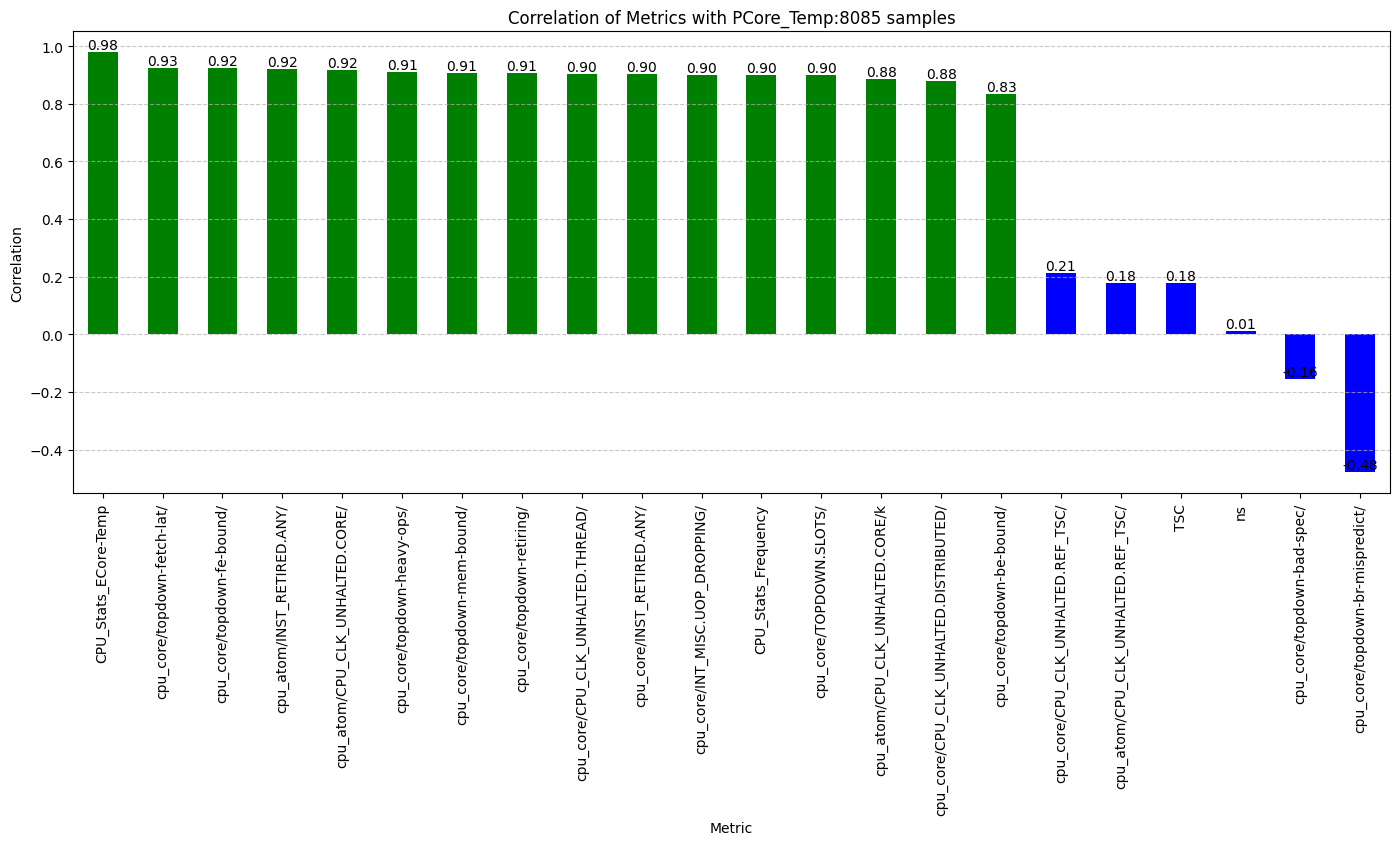

Correlations of each metric with PCore_Temp:8085 samples
metric
CPU_Stats_ECore-Temp                      0.978097
CPU_Stats_Frequency                       0.900342
TSC                                       0.176439
cpu_atom/CPU_CLK_UNHALTED.CORE/           0.915171
cpu_atom/CPU_CLK_UNHALTED.CORE/k          0.884407
cpu_atom/CPU_CLK_UNHALTED.REF_TSC/        0.177860
cpu_atom/INST_RETIRED.ANY/                0.919399
cpu_core/CPU_CLK_UNHALTED.DISTRIBUTED/    0.877800
cpu_core/CPU_CLK_UNHALTED.REF_TSC/        0.212884
cpu_core/CPU_CLK_UNHALTED.THREAD/         0.903122
cpu_core/INST_RETIRED.ANY/                0.902474
cpu_core/INT_MISC.UOP_DROPPING/           0.901169
cpu_core/TOPDOWN.SLOTS/                   0.898122
cpu_core/topdown-bad-spec/               -0.155186
cpu_core/topdown-be-bound/                0.833525
cpu_core/topdown-br-mispredict/          -0.479106
cpu_core/topdown-fe-bound/                0.922356
cpu_core/topdown-fetch-lat/               0.925361
cpu_core/topdown-h

In [240]:
## BLOCK 7 OF CODE - CORRELATION TO OTHER COUNTERS and CORRELATION TO THE TARGET TEMPERATURE.

# This box is for the correlatoin of the counters to the target p-core temperature 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df = df[df['metric'] != 'NA'].copy()
# Step 1: Aggregate to ensure unique timestamp-metric combinations
aggregated_df = filtered_df.groupby(['timestamp', 'metric'], as_index=False).agg({
    'metadata': 'mean'  # Use 'mean' to resolve duplicates; replace with 'sum' or 'max' as needed
})

# Step 2: Verify no duplicates remain
if aggregated_df.duplicated(subset=['timestamp', 'metric']).any():
    print("Duplicates still exist after aggregation.")
else:
    print("No duplicates found; safe to pivot.")

# Step 3: Pivot the metrics to have one column per unique metric
#pivoted_df = aggregated_df.pivot(index='timestamp', columns='metric', values='metadata')

# Step 4: Add PCore_Temp back as a column to the pivoted DataFrame
#pivoted_df = pd.merge(pivoted_df, target_df, on='timestamp', how='inner')

# Assuming `aggregated_df` is the DataFrame
pivoted_df = aggregated_df.pivot(index='timestamp', columns='metric', values='metadata')

# Reset the index for a cleaner DataFrame
pivoted_df = pivoted_df.reset_index()

#pivoted_df = pivoted_df.fillna(0) 

# Step 5: Compute the correlation matrix
#correlation_matrix = pivoted_df.drop(columns=['timestamp', 'TSC', 'ns']).corr()
correlation_matrix = pivoted_df.drop(columns=['timestamp']).corr()


# Extract correlations with PCore_Temp
correlation_with_target = correlation_matrix['CPU_Stats_PCore-Temp'].drop('CPU_Stats_PCore-Temp')

colors = ['green' if value >= 0.75 else 'blue' for value in correlation_with_target.sort_values(ascending=False)]

# Step 6: Plot the correlations
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 6))
bars = correlation_with_target.sort_values(ascending=False).plot(kind='bar', color=colors, title=f"Correlation of Metrics with PCore_Temp:{numSamples} samples")

# Annotate the bars with their values
for bar in bars.patches:
    plt.annotate(
        format(bar.get_height(), '.2f'),  # Format the value
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position at the top of the bar
        ha='center', va='bottom',  # Center alignment
        fontsize=10, color='black'  # Font styling
    )

plt.xlabel('Metric')
plt.ylabel('Correlation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print correlations for reference
print(f"Correlations of each metric with PCore_Temp:{numSamples} samples")
print(correlation_with_target)

/tmp/ipykernel_458601/2437818268.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  colored_matrix = correlation_matrix.applymap(color_map)


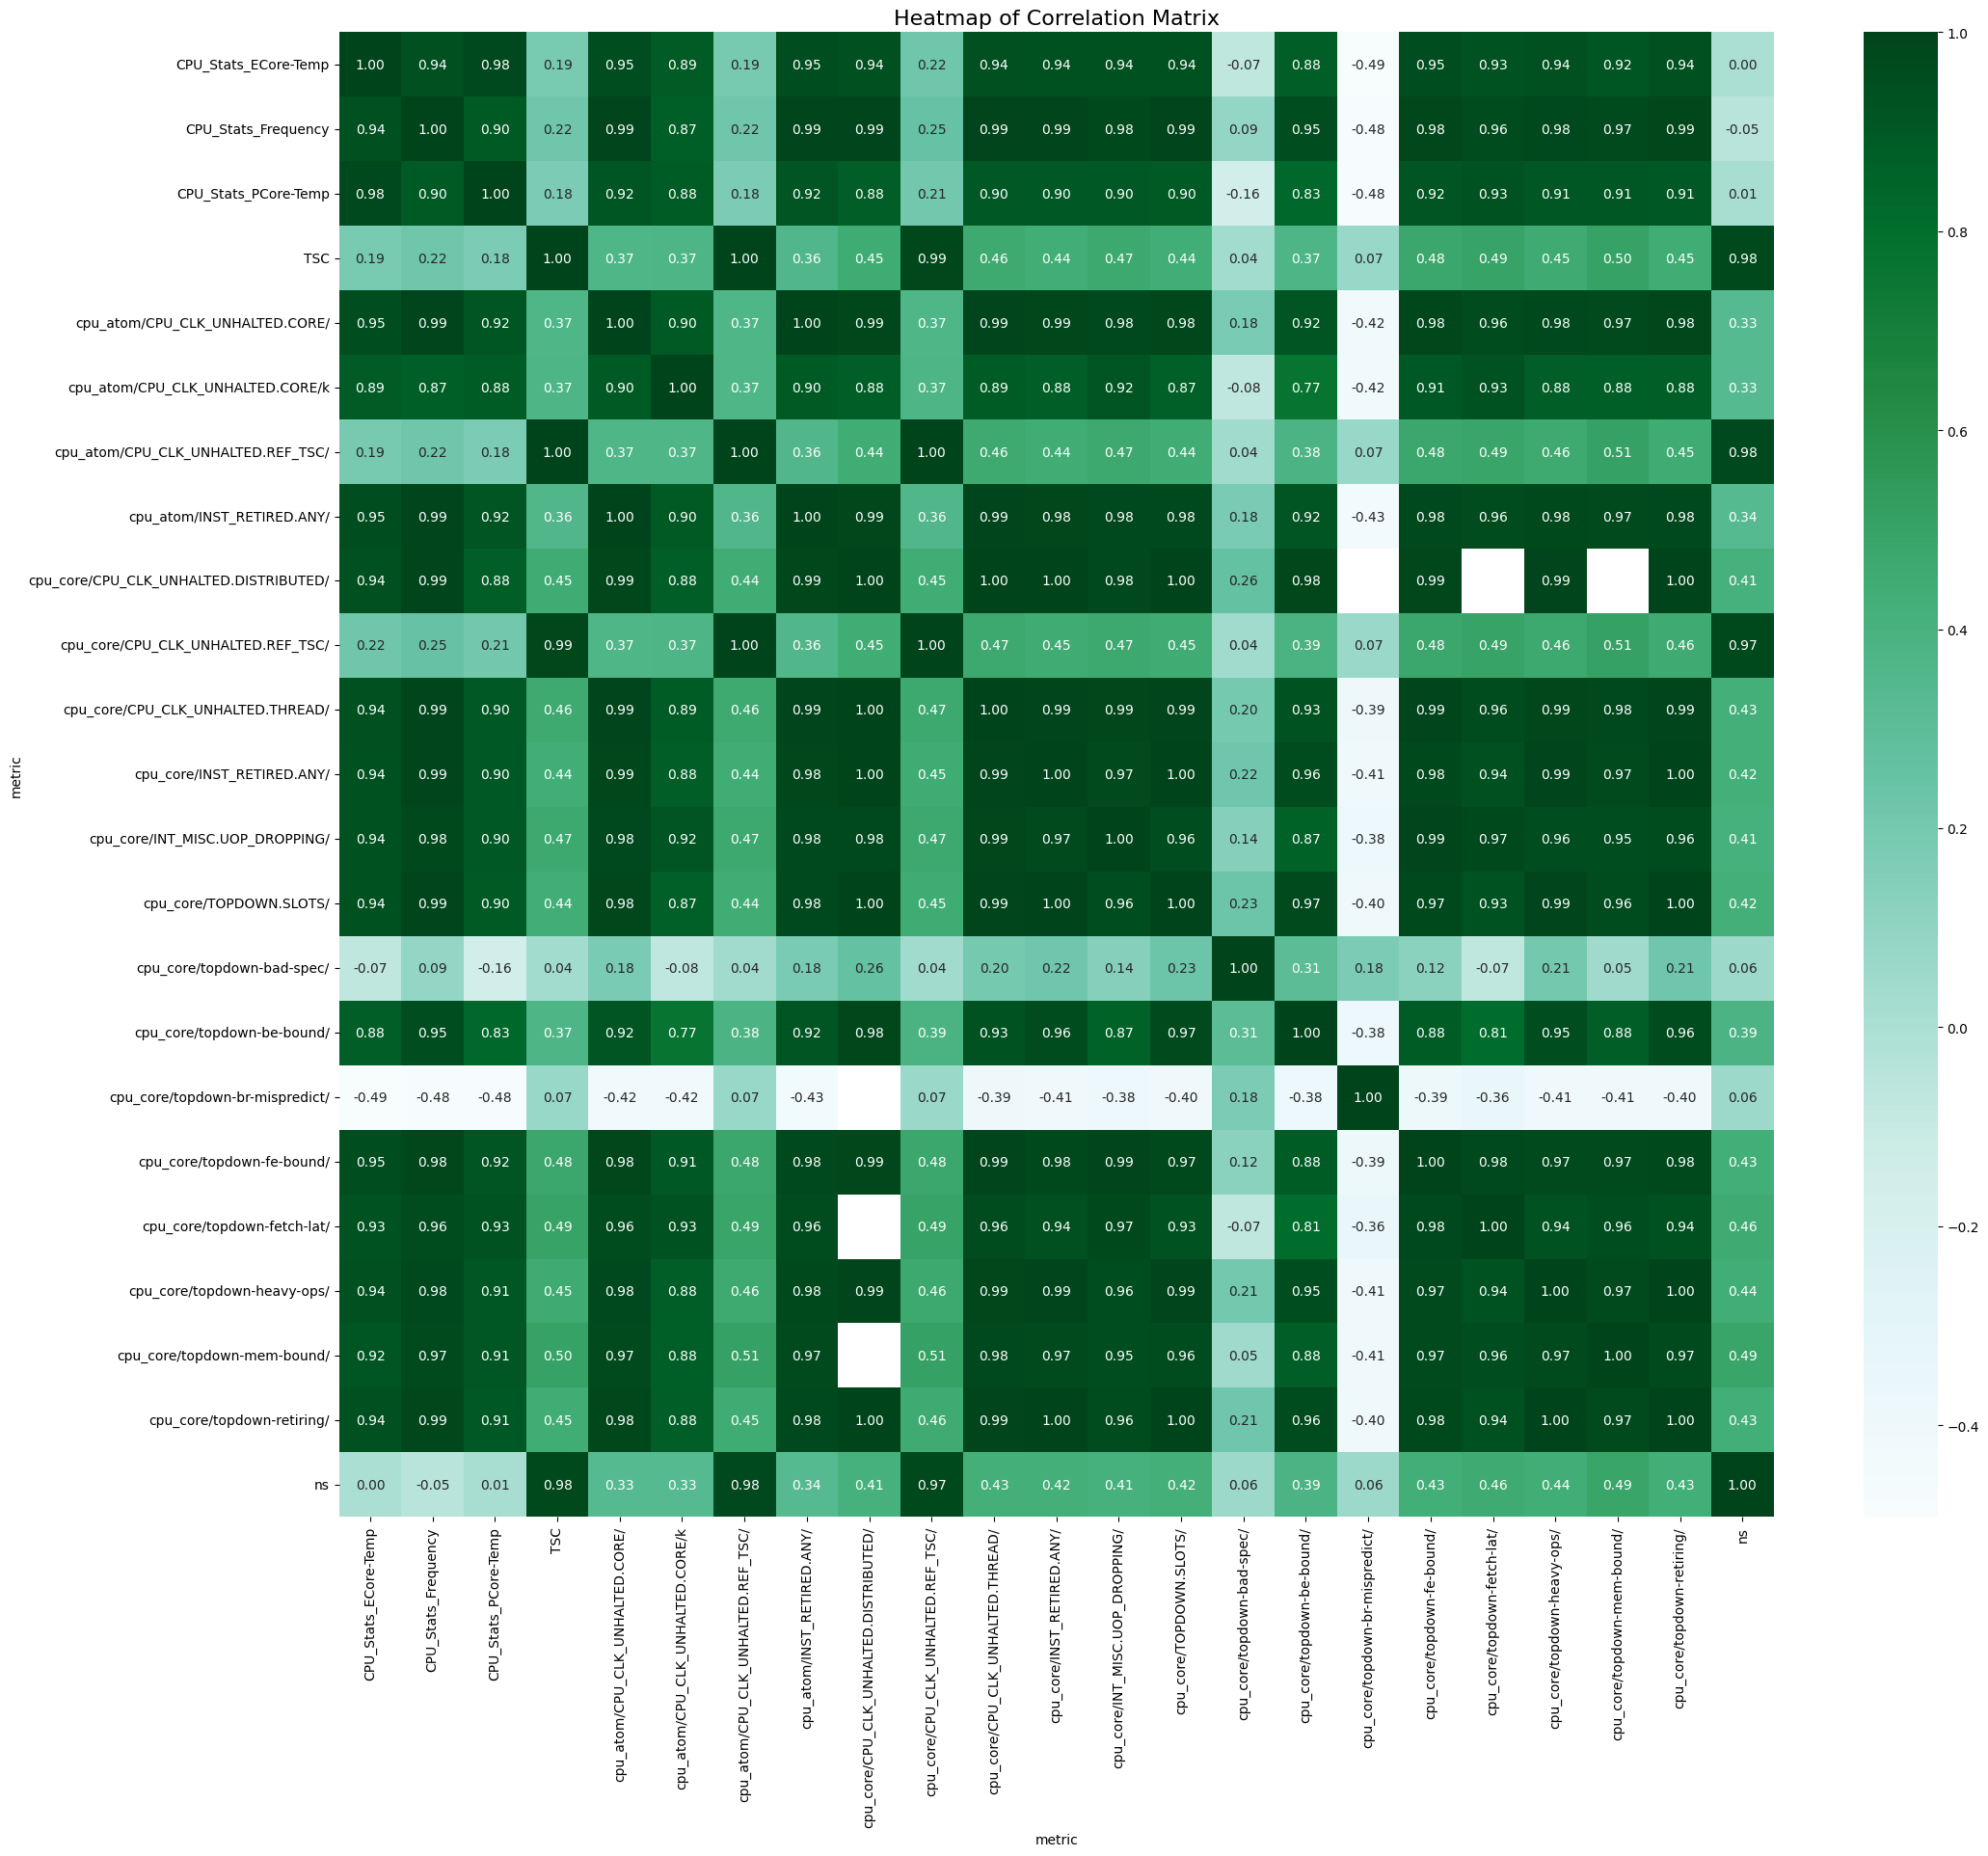

In [241]:
## BLOCK 8 OF CODE - CORRELATION TO OTHER COUNTERS


# Parse the correlation data

#correlation_matrix = pd.read_csv(io.StringIO(data), sep="\t", index_col=0)



# Custom colormap logic for values

def color_map(val):
    if val < 0.75:
        return 'white'
    elif 0.75 <= val <= 0.8:
        return 'lightgreen'
    else:
        return 'darkgreen'


# Apply custom colormap to dataframe for highlighting
colored_matrix = correlation_matrix.applymap(color_map)

# Plot the heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="BuGn", cbar=True)
plt.title("Heatmap of Correlation Matrix", fontsize=16)

plt.show()

No duplicates found; safe to pivot.
Linear Reg: Mean Absolute Error (MAE): 0.93
Linear Reg: Root Mean Squared Error (RMSE): 1.84
Linear Reg: R-squared (Accuracy): 0.96


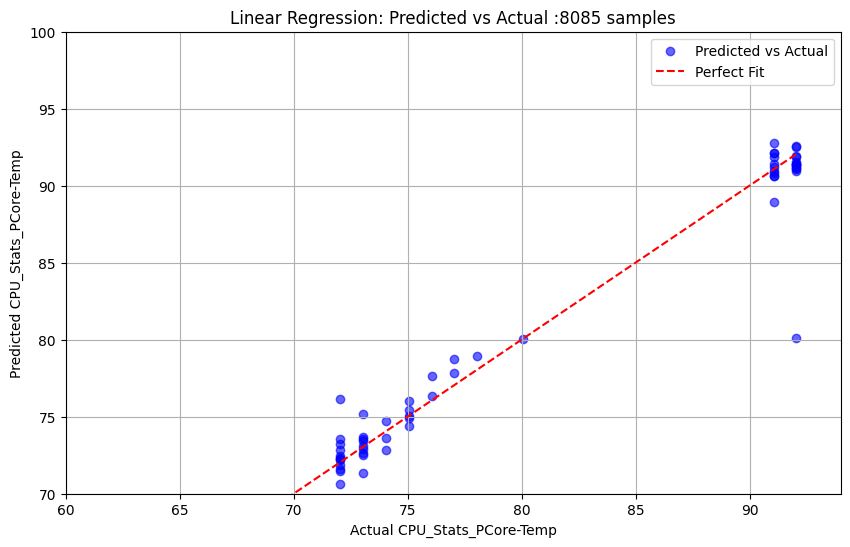

NameError: name 'y_binary' is not defined

In [242]:
## BLOCK 9 OF CODE - PLOT THE ACTUAL VS PREDICTED VALUE OF TEMPERATURE !!!! 


# Linear regression plots preparation to be done after the counter collections either in L3/L1/L1/Summary stuff or otherwise.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
import matplotlib.pyplot as plt

# Load the dataset
#df = pd.read_csv("your_sample_data.csv")  # Replace with actual DataFrame loading

filtered_df = df[df['metric'] != 'NA'].copy()
# Step 1: Aggregate to ensure unique timestamp-metric combinations
aggregated_df = filtered_df.groupby(['timestamp', 'metric'], as_index=False).agg({
    'metadata': 'mean'  # Use 'mean' to resolve duplicates; replace with 'sum' or 'max' as needed
})

# Step 2: Verify no duplicates remain
if aggregated_df.duplicated(subset=['timestamp', 'metric']).any():
    print("Duplicates still exist after aggregation.")
else:
    print("No duplicates found; safe to pivot.")


# Step 1: Data Preparation
# Extract target and features
target_metric = 'CPU_Stats_PCore-Temp'
features = ['metadata']  # List of all other metrics
#df_filtered = df[df['metric'] != target_metric]


# Pivot the data to have one row per timestamp and one column per metric
df_pivoted = aggregated_df.pivot(index='timestamp', columns='metric', values='metadata').reset_index()

# Extract X (features) and y (target)
X = df_pivoted.drop(columns=['timestamp', target_metric])
y = df_pivoted[target_metric]
y = y.fillna(0) 



# Fill missing values if any
X = X.fillna(0)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)


# Calculate errors
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)  # R-squared (Accuracy for regression)

# Print the errors
print(f"Linear Reg: Mean Absolute Error (MAE): {mae:.2f}")
print(f"Linear Reg: Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Linear Reg: R-squared (Accuracy): {r2:.2f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title(f'Linear Regression: Predicted vs Actual :{numSamples} samples')
plt.xlabel('Actual CPU_Stats_PCore-Temp')
plt.ylabel('Predicted CPU_Stats_PCore-Temp')
plt.legend()
plt.grid(True)
plt.xlim(60, 94)
plt.ylim(70, 100)
plt.show()

# Step 4: Classification (High vs Low Temperature)
# Binarize the target (e.g., High Temp > 50)
#y_binary = (y > 50).astype(int)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bin, y_train_bin)
y_pred_bin = log_reg.predict(X_test_bin)

# Evaluate Classification
accuracy = accuracy_score(y_test_bin, y_pred_bin)
print(f"Logistic Classification Accuracy: {accuracy:.2f}")

# Step 5: Errors (Regression)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Logistic Mean Absolute Error (MAE): {mae:.2f}")
print(f"Logistic Root Mean Squared Error (RMSE): {rmse:.2f}")



import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df_pivoted.corr()

# Extract correlations with the target metric
correlation_with_target = correlation_matrix['CPU_Stats_PCore-Temp'].drop('CPU_Stats_PCore-Temp')

# Convert to DataFrame for easy plotting
correlation_df = correlation_with_target.reset_index()
correlation_df.columns = ['Metric', 'Correlation']

# Sort by absolute correlation for better visualization
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Create a seaborn barplot
plt.figure(figsize=(14, 8))
sns.barplot(data=correlation_df, x='Correlation', y='Metric', palette='Blues_r')

# Annotate bar values
for index, row in correlation_df.iterrows():
    plt.text(row['Correlation'], index, f"{row['Correlation']:.2f}", color='black', va='top')

# Add title and labels
plt.title("Correlation of Metrics with CPU_Stats_PCore-Temp", fontsize=16)
plt.xlabel("Correlation", fontsize=14)
plt.ylabel("Metric", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()


In [ ]:
"""

#this code decorates data for the non-TMA based counters. 

import re

# Columns for structured data

columns = ['timestamp', 'value', 'metric', 'metadata','frequency', 'PCore-Temp', 'ECore-Temp']

#create a filter on the % items 
filteredInMetricPercentage = ['cpu_atom/branch-misses/' , 'cpu_core/branch-misses/']
filteredInMetricGHz = ['cpu_core/cycles/', 'cpu_atom/cycles/']
filteredInMetricPerSec = [ 'cpu-migrations', 'page-faults']

parsed_data = []

for line in readjustedList:

    valueMultiplier = 0
    # Check if any value in the list is in the string
    is_match_percenttype = any(value in line for value in filteredInMetricPercentage)
    is_match_GHz = any(value in line for value in filteredInMetricGHz)
    is_match_per_second = any(value in line for value in filteredInMetricPerSec)
    match_cpustats = re.match(r'(\d+\.\d+)\s+stress-ng.*therm:\s+(\d+\.\d+)', line)

    if is_match_percenttype == True:
        valueMultiplier = 100
    if is_match_GHz == True:
        valueMultiplier = 10 #MHz conversion
    if is_match_per_second == True or match_cpustats:
        valueMultiplier = 1

    if valueMultiplier == 0:
        continue

    # Regex to extract timestamp, value, metric, and metadata
    match = re.match(r'(\d+\.\d+)\s+([\d,]+)\s+([\w./-]+)\s+#\s+([\w./-]+)', line)
    match2 = re.match(r'(\d+\.\d+)\s+([\d,\d+.\d+]+)\s+([\w./-]+)\s+([\w./-]+)\s+#\s+([\w./-]+)', line)
    if match:
        timestamp, value, metric, metadata = match.groups()
        # Clean and convert data
        value = int(value.replace(',', ''))  # Remove commas and convert to int
        if metadata == None: 
            metadata = float(0)
        parsed_data.append([float(timestamp), value, metric.strip(), float(metadata.strip())*valueMultiplier,0,0,0])

    elif match2: 
        timestamp, value, unit, metric, metadata = match2.groups()
        # Clean and convert data
        #value = int(value.replace(',', ''))  # Remove commas and convert to int
        if metadata == None: 
            metadata = float(0)
        parsed_data.append([float(timestamp), value, metric.strip(), float(metadata.strip())*valueMultiplier,0,0,0])
        
    else:  # for the power matrix.
        if match_cpustats:    
            #timestamp, frequency = match_cpustats.groups()
            #print(f"{timestamp, frequency}")
            
            # Regex to match all floating-point numbers
            pattern = r"\d+\.\d{2}"
            # Find all matches
            matches = re.findall(pattern, line)
            if matches:
                # Select specific positions: 1st (3.40), 10th (86.05), and 11th (91.00)
                positions = [0,1, 10, 11]  # Adjusted for zero-based indexing
                selected_values = [matches[pos] for pos in positions]
                #print(selected_values[0], selected_values[1], selected_values[2],  selected_values[3])
                parsed_data.append([float(selected_values[0]), float(selected_values[1]), "CPU_Stats_Frequency", float(selected_values[1])*100, float(selected_values[1]), 0, 0])
                parsed_data.append([float(selected_values[0]), float(selected_values[2]), "CPU_Stats_PCore-Temp", float(selected_values[2])*valueMultiplier, 0, float(selected_values[2]), 0])
                parsed_data.append([float(selected_values[0]), float(selected_values[3]), "CPU_Stats_ECore-Temp", float(selected_values[3])*valueMultiplier, 0, 0, float(selected_values[3])])

# Convert parsed data into a DataFrame
df = pd.DataFrame(parsed_data, columns=columns)
# Display a summary of the parsed data for validation
#df.head(50)

#matching_rows = df[df['metric'] == "CPU_Stats_PCore-Temp"]
#print(matching_rows)
"""

In [ ]:

# The pivoting issue seems to be due to duplicate timestamps.
# To resolve this, we'll group by timestamp and metric, summing the values if duplicates exist.
"""
metrics_to_plot = ['context-switches', 'cpu-migrations']

grouped_df = filtered_df.groupby(['timestamp', 'metric'], as_index=False)['value'].sum()
pivoted_df = grouped_df.pivot(index='timestamp', columns='metric', values='value')

# Plot the metrics over time
plt.figure(figsize=(14, 8))
for metric in metrics_to_plot:
    if metric in pivoted_df.columns:
        plt.plot(pivoted_df.index, pivoted_df[metric], label=metric)


plt.title("Compute Counters Over Time", fontsize=12)
plt.xlabel("Timestamp (s)", fontsize=12)
plt.ylabel("Value", fontsize=12)
samples = len(frequency_array)
samples = "CPU Counters: " + str(samples) + " Samples\n\n"
plt.legend(title= samples, fontsize=12)
plt.grid(True)
plt.show()
"""

In [ ]:
df.head(50)